In [34]:
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

import os, sys, traceback
import cPickle as pickle

%matplotlib inline
import matplotlib.pylab as plt

from sigvisa.models.ttime import tt_predict
from sigvisa.utils.array import time_to_index, index_to_time

from sigvisa.infer.correlations.ar_correlation_model import ar_advantage

In [35]:
with open("/home/dmoore/python/sigvisa/logs/mcmc/01147/step_000063/pickle.sg", 'rb') as f:
    sg = pickle.load(f)

In [36]:
wn = sg.station_waves["NV01"][0]
eid = 1
phase = "Lg"
tmnodes = sg.get_template_nodes(eid, wn.sta, phase, wn.band, wn.chan)

lp = wn.log_p()

k_atime, n_atime = tmnodes['arrival_time']
current_atime = n_atime.get_value(key=k_atime)

ev = wn.graph.get_event(eid) #hack
pred_atime = ev.time + tt_predict(ev, wn.sta, phase)

relevant_nodes = [wn,]
relevant_nodes += [n_atime.parents[n_atime.default_parent_key()],] if n_atime.deterministic() else [n_atime,]

cssm = wn.arrival_ssms[(eid, phase)]
(start_idxs, end_idxs, identities, basis_prototypes, level_sizes, n_steps) = wn.wavelet_basis

if wn.has_jointgp:
    cond_means, cond_vars = zip(*[jgp.posterior(eid) for jgp in wn.wavelet_param_models[phase]])
    cond_means, cond_vars = np.asarray(cond_means, dtype=np.float64), np.asarray(cond_vars, dtype=np.float64)
    cssm.set_coef_prior(cond_means, cond_vars)

pred_wavelet = cssm.mean_obs(n_steps)

if wn.has_jointgp:
    wn._set_cssm_priors_from_model(arrivals=[(eid, phase)])

tmvals, tg = wn.get_template_params_for_arrival(eid, phase)
env = np.exp(tg.abstract_logenv_raw(tmvals, srate=wn.srate, fixedlen=n_steps))
pred_signal = pred_wavelet * env

pbu = wn.unexplained_kalman(exclude_arrivals=[(eid,phase)])
#pbu = wn.get_value()
relevant_sidx = time_to_index(pred_atime - 20.0, wn.st, wn.srate)
relevant_stime = index_to_time(relevant_sidx, wn.st, wn.srate)
relevant_eidx = time_to_index(pred_atime + 20.0, wn.st, wn.srate) + len(pred_signal)
relevant_etime = index_to_time(relevant_eidx, wn.st, wn.srate)
if relevant_sidx < 0 or relevant_eidx > len(pbu):
    import pdb; pdb.set_trace()

relevant_signal = pbu[relevant_sidx:relevant_eidx]

atime_ll = ar_advantage(relevant_signal, pred_signal, wn.nm)

def idx_to_atime(proposed_idx):
    return index_to_time(proposed_idx, relevant_stime, wn.srate)

def atime_to_idx(proposed_atime):
    return time_to_index(proposed_atime, relevant_stime, wn.srate)

# temper the proposal distribution a bit
maxll = np.max(atime_ll)
if maxll > 10:
    atime_ll /= maxll/10.0
    maxll = 10.0
atime_ll += 1.0

t = np.linspace(relevant_stime, relevant_etime, len(atime_ll))
prior_lp = -np.abs( (t-pred_atime)/3.0)
atime_ll += prior_lp

proposal_dist = np.exp(atime_ll - maxll)
proposal_dist /= np.sum(proposal_dist)
proposed_idx = np.random.choice(np.arange(len(proposal_dist)), p=proposal_dist)
proposed_atime = idx_to_atime(proposed_idx)

log_qforward = np.log(proposal_dist[proposed_idx])
backwards_idx = atime_to_idx(current_atime)

#assert(  atime_to_idx(idx_to_atime(proposed_idx)) == proposed_idx )
#assert(  np.abs(idx_to_atime(atime_to_idx(current_atime)) - current_atime) < wn.srate )

log_qbackward = np.log(proposal_dist[backwards_idx])



In [37]:
print log_qbackward

-0.041357708567


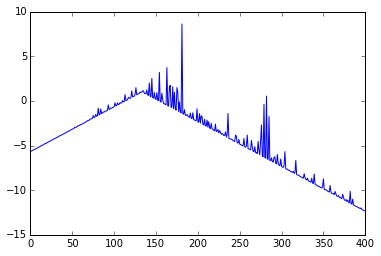

In [38]:
plt.plot(atime_ll)

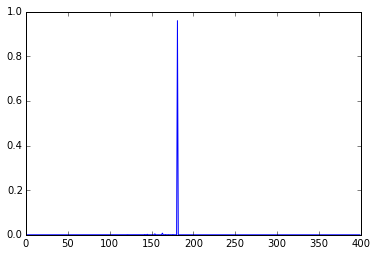

In [39]:
plt.plot(proposal_dist)

In [42]:
print proposed_idx
print backwards_idx

181
181


# Current alignment from wave node

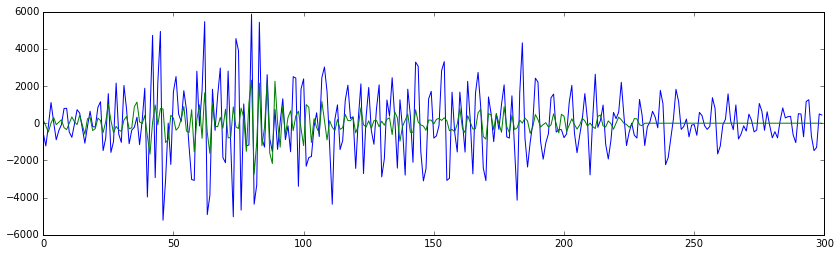

In [41]:
pred_full = wn.tssm.mean_obs(wn.npts)
actual_full = wn.get_value()

plt.figure(figsize=(14, 4))
lg_idx = time_to_index(pred_atime-5.0, wn.st, wn.srate)
plt.plot(actual_full[lg_idx:lg_idx + 300])
plt.plot(pred_full[lg_idx:lg_idx + 300])


# Current alignment in template xc move

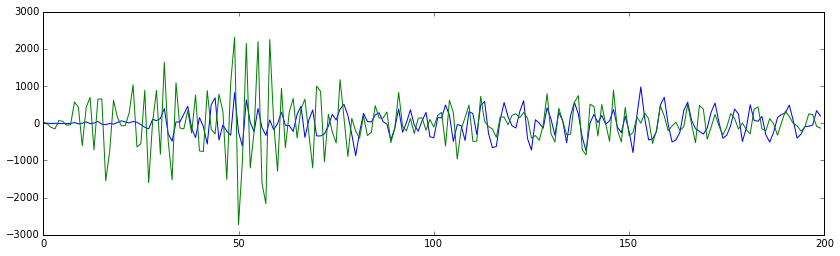

In [25]:
pred_signal = pred_wavelet * env
plt.figure(figsize=(14, 4))
plt.plot(relevant_signal[backwards_idx:backwards_idx + len(pred_signal)])
plt.plot(pred_signal)

# Proposed alignment in template xc move

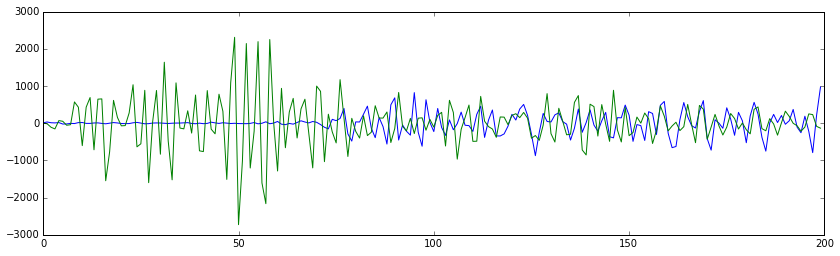

In [29]:
pred_signal = pred_wavelet * env
plt.figure(figsize=(14, 4))
plt.plot(relevant_signal[proposed_idx:proposed_idx + len(pred_signal)])
plt.plot(pred_signal)

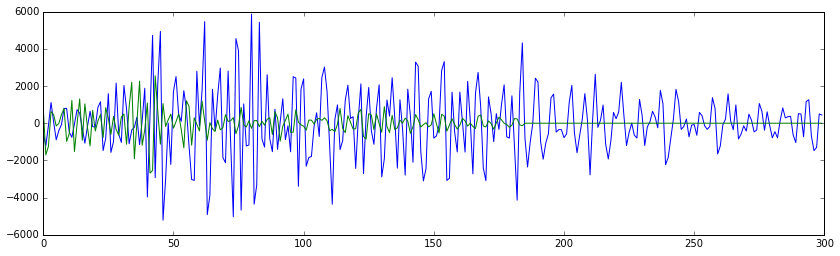

In [31]:
n_atime.set_value(proposed_atime)

wn._parent_values()

pred_full = wn.tssm.mean_obs(wn.npts)
actual_full = wn.get_value()

plt.figure(figsize=(14, 4))
lg_idx = time_to_index(pred_atime-5.0, wn.st, wn.srate)
plt.plot(actual_full[lg_idx:lg_idx + 300])
plt.plot(pred_full[lg_idx:lg_idx + 300])


In [40]:
for (eeid, pphase, scale, sidx, npts, component_type) in wn.tssm_components:
    if eeid != eid or pphase != phase: continue
    if component_type != "wavelet": continue
    print sidx, npts

807 200


In [42]:
print 807-relevant_sidx

181


In [44]:
print backwards_idx

180


In [48]:
print time_to_index(relevant_stime, wn.st, wn.srate)
print relevant_sidx

626
626


In [51]:
#time_to_index(current_atime, wn.st, wn.srate)

print (current_atime - wn.st) * wn.srate

print (current_atime - relevant_stime) * wn.srate


807.311899662
180.826158524
